# Analysis of CL model run

In [4]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import rasterio as rio
import pyvista as pv
import statsmodels.api as sm
from osgeo import gdal
import datetime

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

In [5]:
timestep = 1  # time resolution, 1, 6, or 24 hr
resolution = 1  # resolution of DEM, 1 or 5 m
lasttime = 518400  # output time stamp to plot
cut = 100  # point on x axis to plot cross section of DEM (resolution dependent)
name = 'rain{}hr_{}m_30cmBedrock_k10-2'.format(timestep, resolution)

In [10]:
ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/Elevations{}.asc'.format(name, lasttime)
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)

# the matrix gets fliped when I read it so I add a 180° rotation
z = np.flip(np.flip(data_array, 1), 0)

x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/WaterDepths{}.asc'.format(name, lasttime)
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)

# the matrix gets fliped when I read it so I add a 180° rotation
zwater = np.flip(np.flip(data_array, 1), 0)

water = pv.StructuredGrid(x, y, zwater)
d = np.zeros_like(water.points)
d[:, 1] = water.points[:, 2]

In [11]:
# To modify cpos (position of camera) change notebook=True to False and manipulate the plot
# this will then return the cpos and you can edit this parameter below and re-run the cell
cpos = [(1252.3113078544443, 57.667618592004146, 2771.2269290128343),
        (-998.7813915579818, 1194.0290590469476, -5477.0177030983605),
        (0.4415550130087225, -0.8646424633461258, -0.23963009215374143)]

p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1], cmap='Blues', clim=[0,0.05])
p.camera_position = cpos
p.add_scalar_bar(title='Water Height (m)')
p.show(screenshot='plots/CL_water_{}.png'.format(name))

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

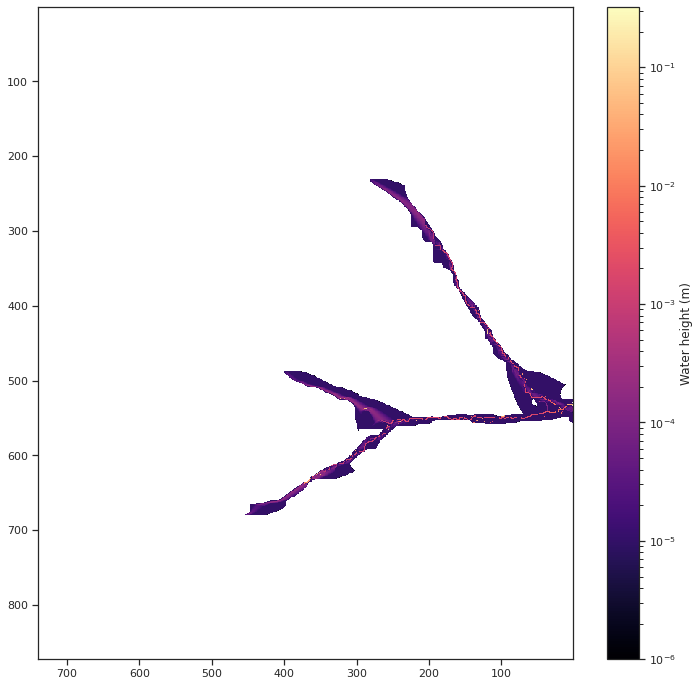

In [13]:
sns.set(rc={'figure.figsize':(12, 12)})
sns.set_style("ticks")
plt.figure()
plt.pcolormesh(x, y, zwater, 
               norm=colors.LogNorm(vmin=1e-6, vmax=zwater.max()),
               cmap='magma', shading='auto')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Water height (m)')
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())
plt.savefig('plots/CL_waterheight_{}.png'.format(name), dpi=300)
plt.show()

In [14]:
maxwater = 0
times = np.arange(14400, lasttime+14400, 14400)
for time in times:
    ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/WaterDepths{}.asc'.format(name, time)
    ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)

    # the matrix gets fliped when I read it so I add a 180° rotation
    zwater = np.flip(np.flip(data_array, 1), 0)
    if np.max(zwater[:]) > maxwater:
        maxwater = np.max(zwater[:])
        maxtime = time
print(time)

518400


In [15]:
ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/Elevations{}.asc'.format(name, lasttime)
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)

# the matrix gets fliped when I read it (180° rotation)
z = np.flip(np.flip(data_array, 1), 0)

x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/Elevations{}.asc'.format(name, 0)
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)

# the matrix gets fliped when I read it (180° rotation)
zstart = np.flip(np.flip(data_array, 1), 0)

z0 = pv.StructuredGrid(x, y,zstart)
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))

In [ ]:
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='plots/CL_DEMdiff_{}.png'.format(name))

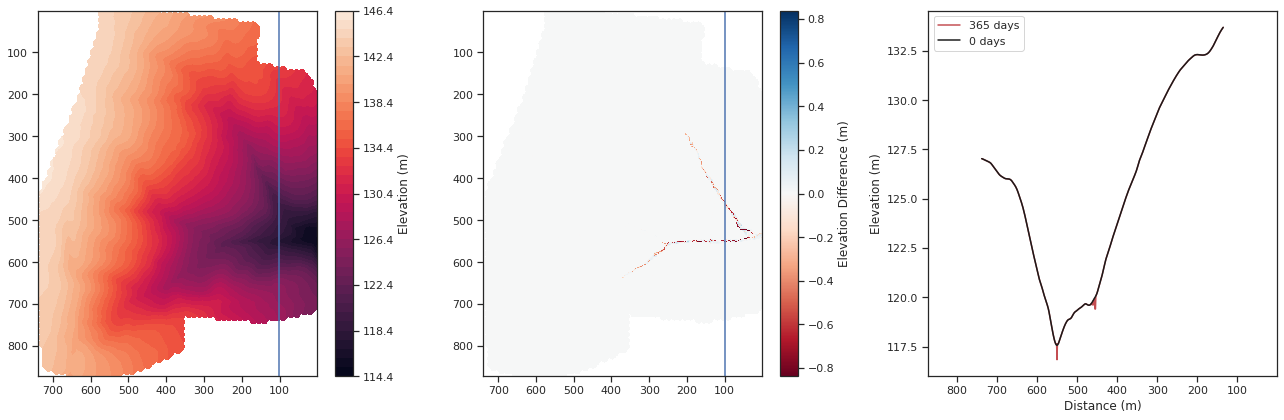

In [17]:
sns.set(rc={'figure.figsize':(18, 6)})
sns.set_style("ticks")
plt.figure()
plt.subplot(1,3,1)
plt.contourf(x, y, z, 50)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation (m)')
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())
plt.plot(x[:,cut], y[:,cut])

plt.subplot(1,3,2)
clim = np.nanmax(np.abs(z-zstart))
plt.pcolormesh(x, y, z-zstart, cmap='RdBu', vmin=-clim, vmax=clim)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation Difference (m)')
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())
plt.plot(x[:,cut], y[:,cut])

plt.subplot(1,3,3)
plt.plot(y[:,cut], z[:,cut], 'r')
plt.plot(y[:,cut], zstart[:,cut], 'k')
plt.xlim(y.max(), y.min())
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.legend(['365 days','0 days'])
plt.tight_layout()
plt.savefig('plots/CL_profile_{}.png'.format(name), dpi=300)
plt.show()

<Figure size 1080x1080 with 0 Axes>

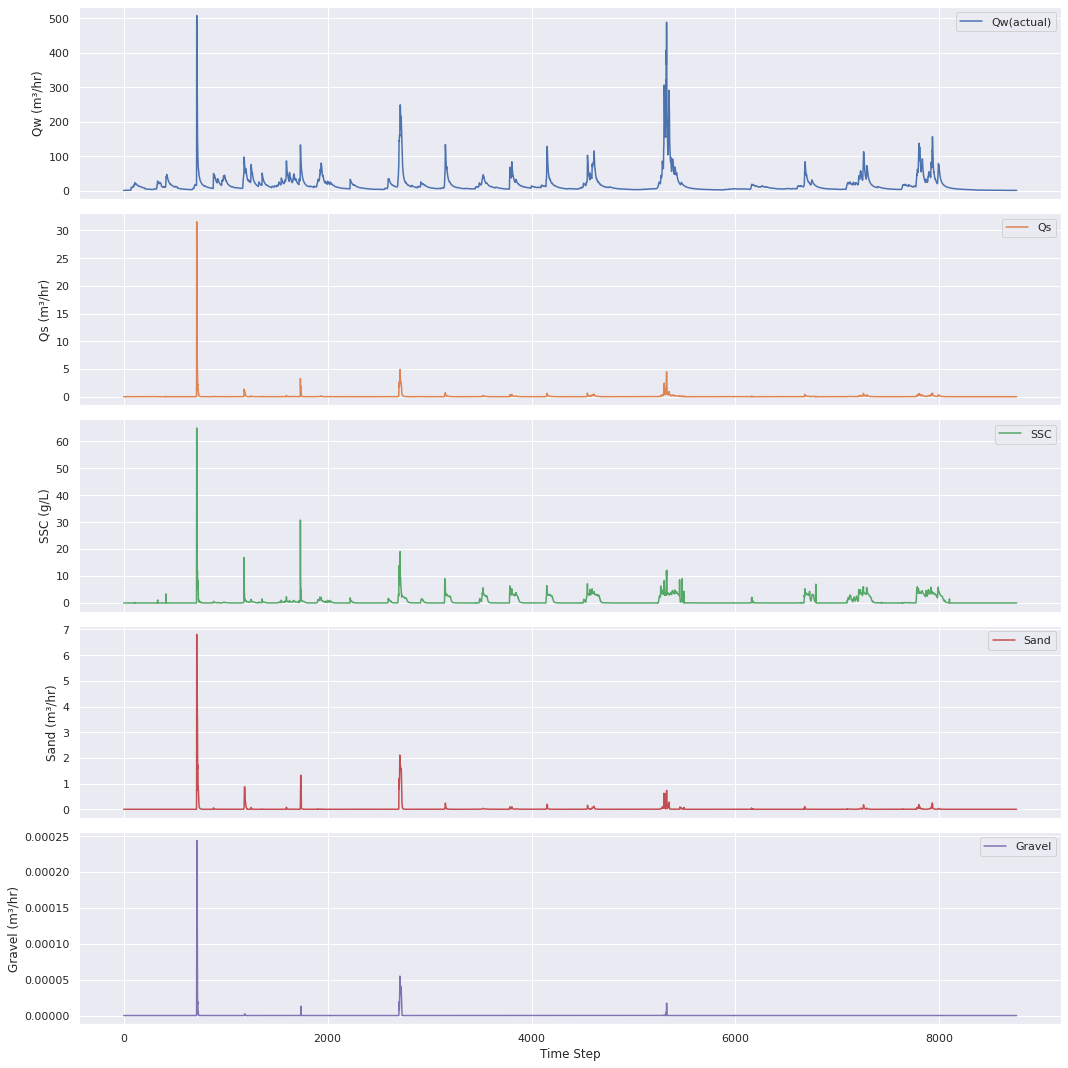

In [18]:
file = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/sedoutput.dat'.format(name)
seds_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
seds_['Qw(actual)'] = seds_['Qw(actual)'] * 60 * 60
density = 1330
rock = 2660
seds_['SSC'] = seds_['Suspended'] * density / seds_['Qw(actual)']
seds_['Bedload'] = (seds_['Sand'] + seds_['Gravel']) * rock / seds_['Qw(actual)']

sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Qw(actual)', 'Qs', 'SSC', 'Sand', 'Gravel']
cols_label = ['Qw (m³/hr)', 'Qs (m³/hr)', 'SSC (g/L)', 'Sand (m³/hr)', 'Gravel (m³/hr)']
axes = seds_[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Time Step')
plt.tight_layout()
plt.show()

<Figure size 1080x1080 with 0 Axes>

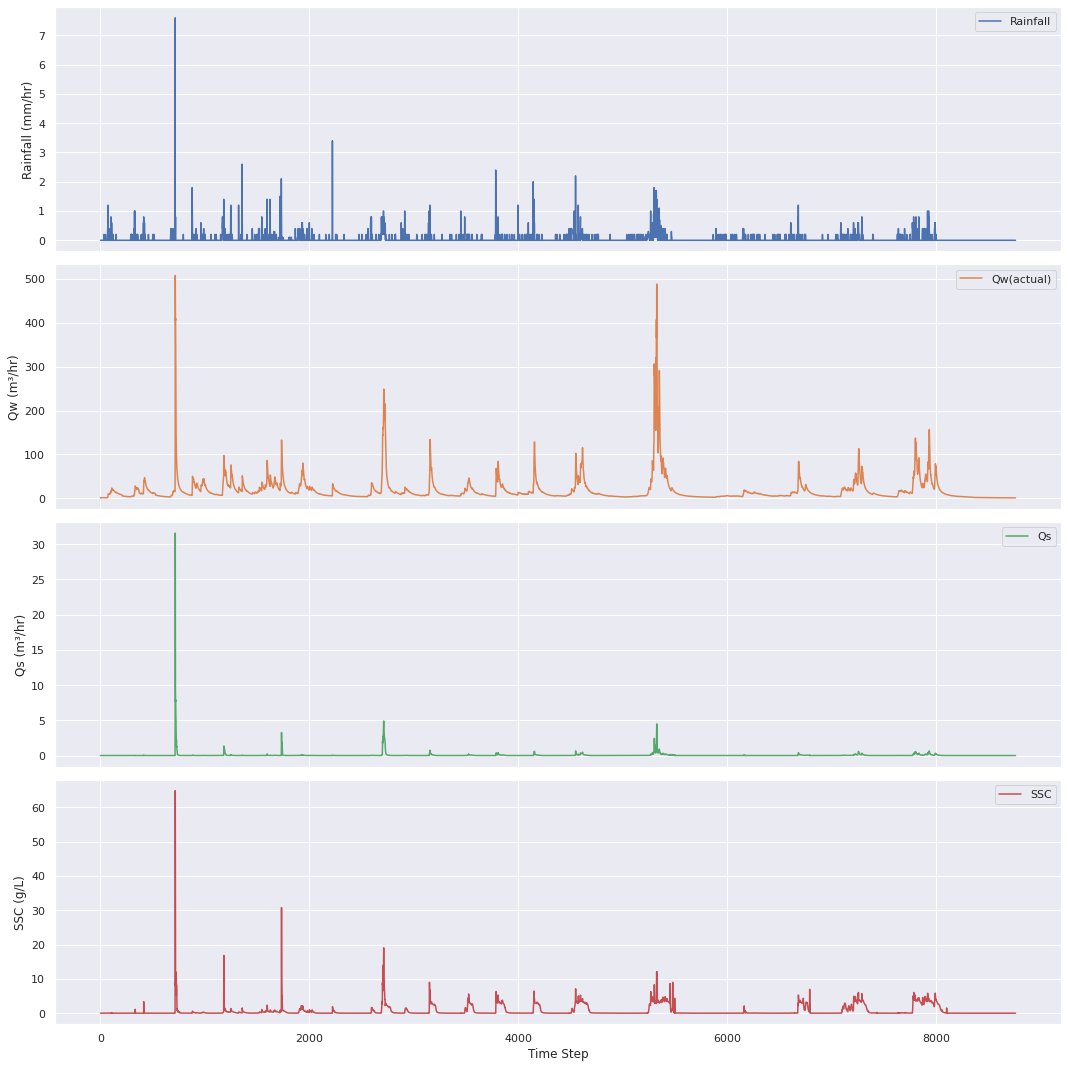

In [19]:
file = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/input_data/rainfall_max{}hr_365days.txt'.format(name, timestep)
rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
seds_all = pd.concat([seds_, rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'SSC']
cols_label = ['Rainfall (mm/hr)', 'Qw (m³/hr)', 'Qs (m³/hr)', 'SSC (g/L)']
axes = seds_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Time Step')
plt.tight_layout()
plt.show()

In [20]:
np.max(seds_all.Suspended.values + seds_all.Sand.values + seds_all.Gravel.values)

31.5747394299

In [21]:
date_rng = pd.date_range(start='4/12/2016 02:00:00', periods=len(seds_all), freq='{}H'.format(timestep))
date_rng

DatetimeIndex(['2016-04-12 02:00:00', '2016-04-12 03:00:00',
               '2016-04-12 04:00:00', '2016-04-12 05:00:00',
               '2016-04-12 06:00:00', '2016-04-12 07:00:00',
               '2016-04-12 08:00:00', '2016-04-12 09:00:00',
               '2016-04-12 10:00:00', '2016-04-12 11:00:00',
               ...
               '2017-04-11 15:00:00', '2017-04-11 16:00:00',
               '2017-04-11 17:00:00', '2017-04-11 18:00:00',
               '2017-04-11 19:00:00', '2017-04-11 20:00:00',
               '2017-04-11 21:00:00', '2017-04-11 22:00:00',
               '2017-04-11 23:00:00', '2017-04-12 00:00:00'],
              dtype='datetime64[ns]', length=8759, freq='H')

In [22]:
seds_all['date'] = date_rng[:len(seds_all)]

In [23]:
seds_all = seds_all.set_index('date', drop=False)

<Figure size 1080x1080 with 0 Axes>

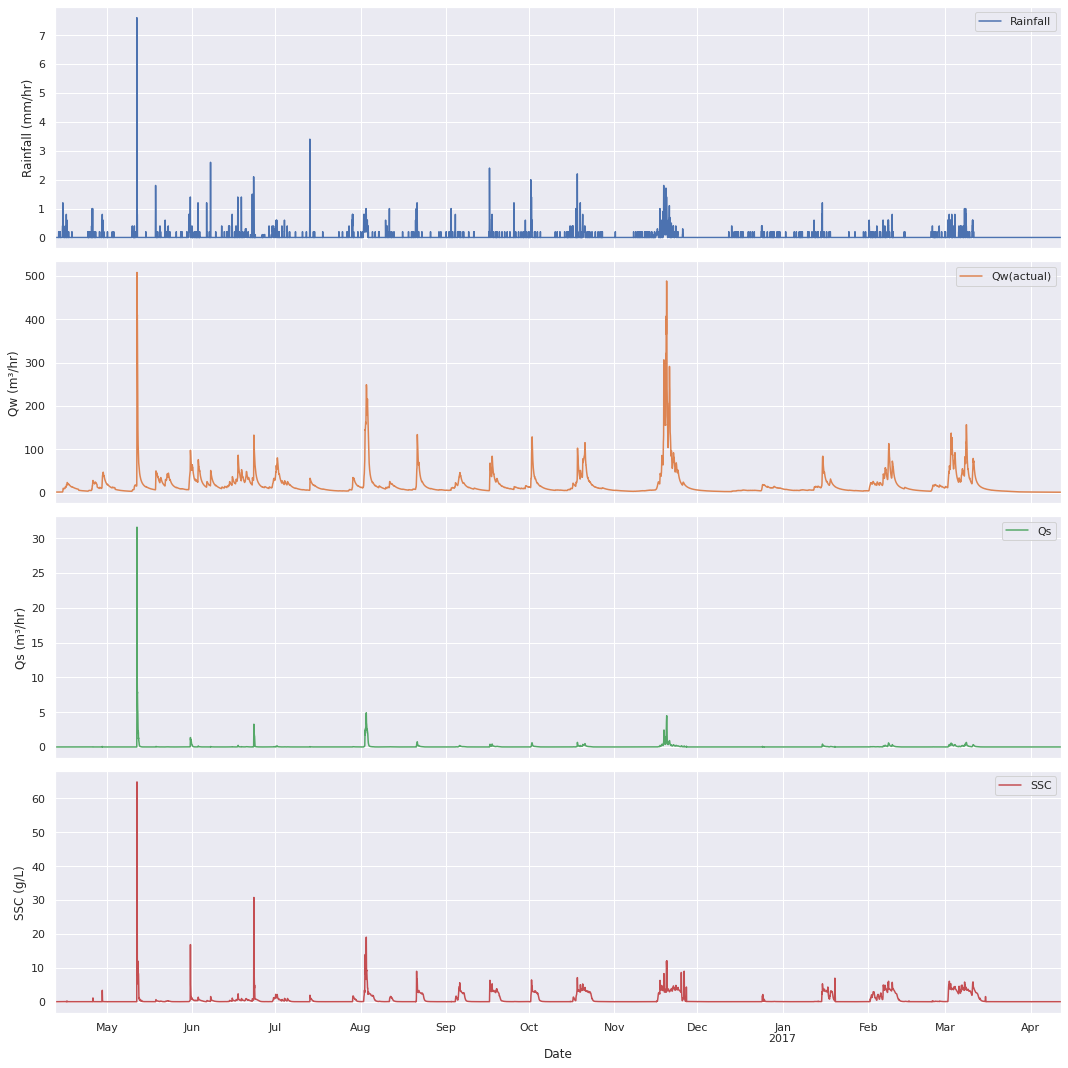

In [24]:
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'SSC']
cols_label = ['Rainfall (mm/hr)', 'Qw (m³/hr)', 'Qs (m³/hr)', 'SSC (g/L)']
axes = seds_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('plots/timeseries_{}.png'.format(name), dpi=300)
plt.show()

<Figure size 1080x1080 with 0 Axes>

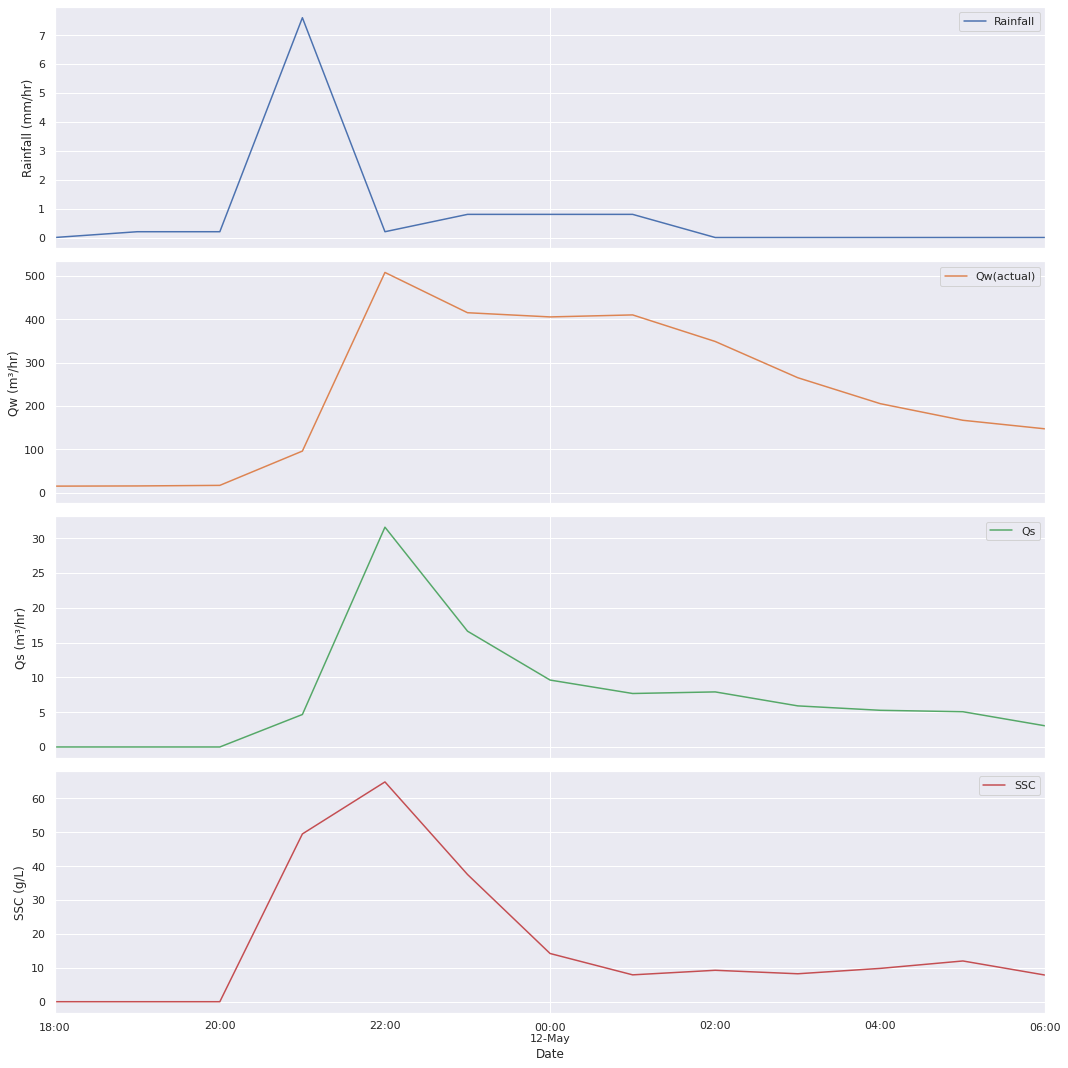

In [25]:
t1 = pd.to_datetime('2016-05-11 18:00:00')
t2 = pd.to_datetime('2016-05-12 06:00:00')

sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'SSC']
cols_label = ['Rainfall (mm/hr)', 'Qw (m³/hr)', 'Qs (m³/hr)', 'SSC (g/L)']
axes = seds_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    plt.xlim(t1, t2)
    i += 1
plt.xlabel('Date')
plt.tight_layout()
plt.show()

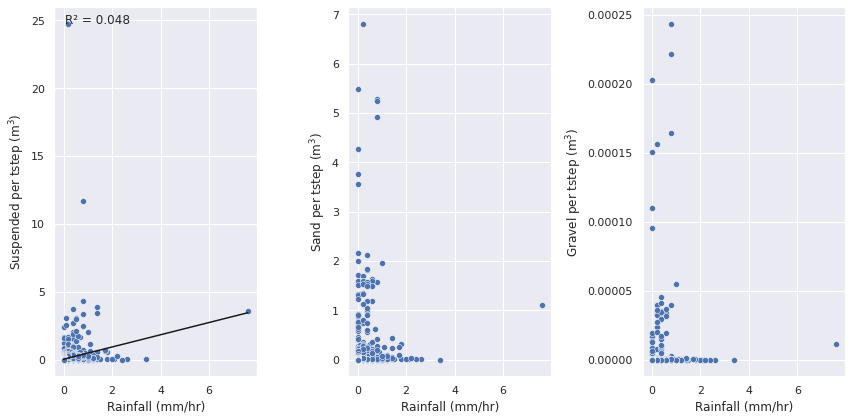

In [26]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(131)

g = sns.scatterplot(seds_all['Rainfall'], seds_all['Suspended'], ax=ax1)

model = sm.OLS(seds_all['Suspended'],sm.add_constant(seds_all['Rainfall']),missing='drop').fit()
xx = np.linspace(seds_all['Rainfall'].min(), seds_all['Rainfall'].max(), 2)
yy = model.params[0] + xx*model.params[1]
plt.plot(xx, yy, 'k')
plt.text(0.05, np.max(seds_all['Suspended']), 'R² = ' + str(np.round(model.rsquared,3)))
#plt.text(0.05, np.max(seds_all['Suspended']), 'R² = ' + str(seds_all['Rainfall'].max()))

g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(132)
g = sns.scatterplot(seds_all['Rainfall'], seds_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax3 = plt.subplot(133)
g = sns.scatterplot(seds_all['Rainfall'], seds_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
#plt.savefig('yield_precip_{}.jpg'.format(name))
plt.show()

In [27]:
events = []
dates_start = ['04/11/2016', '05/11/2016', '05/30/2016', '06/22/2016', '08/02/2016']
dates_end = ['04/14/2016', '05/13/2016', '06/02/2016', '06/25/2016', '08/05/2016']
for i, date_start in enumerate(dates_start):
    date_end = dates_end[i]
    events.append(seds_all.index[(seds_all['date'] >= date_start) & (seds_all['date'] <= date_end)].to_list())

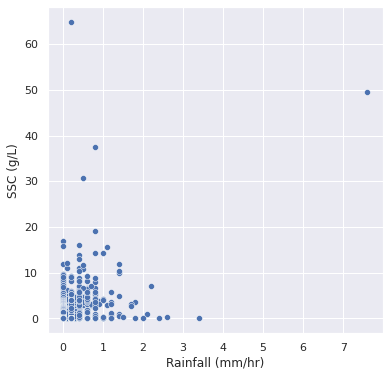

In [28]:
plt.figure(figsize=(6,6))

g = sns.scatterplot(seds_all['Rainfall'], seds_all['SSC'])

g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' (g/L)')

plt.show()

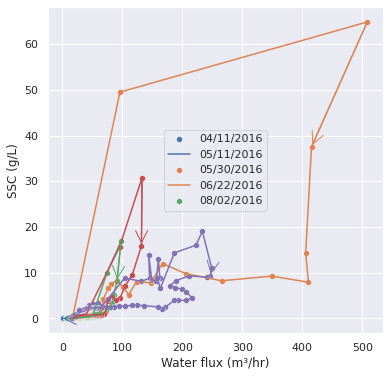

In [29]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.max()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

plt.figure(figsize=(6,6))

for event in events:
    g = sns.scatterplot(x=seds_all['Qw(actual)'][event], y=seds_all['SSC'][event])
    line = plt.plot(seds_all['Qw(actual)'][event], seds_all['SSC'][event])[0]
    if timestep != 24:
        add_arrow(line, size=30)

plt.xlabel('Water flux (m³/hr)')
plt.ylabel('SSC (g/L)')

plt.legend(dates_start)
plt.savefig('plots/hysterisis_{}.png'.format(name), dpi=300)
plt.show()

In [30]:
window_times = [np.int(2 * 24 / timestep), np.int(5 * 24 / timestep), np.int(10 * 24 / timestep)]
windows = [2, 5, 10]
for i, window in enumerate(windows):
    
    seds_all['Rainfall Rolling Std. ' + str(window)] = seds_all['Rainfall'].rolling(window_times[i]).std().values
    seds_all['Rainfall Rolling Mean. ' + str(window)] = seds_all['Rainfall'].rolling(window_times[i]).mean().values
    seds_all['Rainfall Rolling Median. ' + str(window)] = seds_all['Rainfall'].rolling(window_times[i]).median().values
    
    seds_all['Suspended Rolling Std. ' + str(window)] = seds_all['SSC'].rolling(window_times[i]).std().values
    seds_all['Suspended Rolling Mean. ' + str(window)] = seds_all['SSC'].rolling(window_times[i]).mean().values
    seds_all['Suspended Rolling Median. ' + str(window)] = seds_all['SSC'].rolling(window_times[i]).median().values
    
    seds_all['Sand Rolling Std. ' + str(window)] = seds_all['Sand'].rolling(window_times[i]).std().values
    seds_all['Sand Rolling Mean. ' + str(window)] = seds_all['Sand'].rolling(window_times[i]).mean().values
    seds_all['Sand Rolling Median. ' + str(window)] = seds_all['Sand'].rolling(window_times[i]).median().values
    
    seds_all['Gravel Rolling Std. ' + str(window)] = seds_all['Gravel'].rolling(window_times[i]).std().values
    seds_all['Gravel Rolling Mean. ' + str(window)] = seds_all['Gravel'].rolling(window_times[i]).mean().values
    seds_all['Gravel Rolling Median. ' + str(window)] = seds_all['Gravel'].rolling(window_times[i]).median().values

/tmp/ipykernel_6404/2436340507.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_times = [np.int(2 * 24 / timestep), np.int(5 * 24 / timestep), np.int(10 * 24 / timestep)]


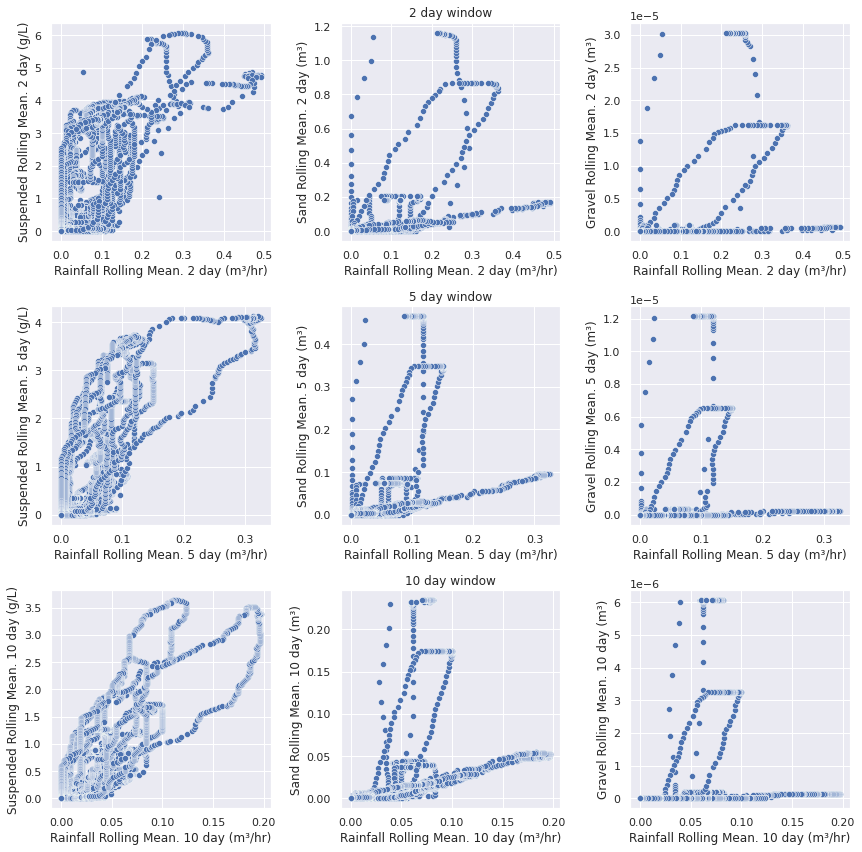

In [31]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    
    model = sm.OLS(seds_all['Suspended Rolling Mean. ' + str(window)],sm.add_constant(seds_all['Rainfall Rolling Mean. ' + str(window)],),missing='drop').fit()
    xx = np.linspace(np.min(seds_all['Rainfall Rolling Mean. ' + str(window)]), np.max(seds_all['Rainfall Rolling Mean. ' + str(window)]), 2)
    yy = model.params[0] + xx*model.params[1]
    # plt.plot(xx, yy, 'k')
    # plt.text(0.05, np.max(seds_all['Suspended Rolling Mean. ' + str(window)]), 'R² = ' + str(np.round(model.rsquared,3)))
    
    g = sns.scatterplot(seds_all['Rainfall Rolling Mean. ' + str(window)],
                        seds_all['Suspended Rolling Mean. ' + str(window)], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (m³/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (g/L)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(seds_all['Rainfall Rolling Mean. ' + str(window)],
                        seds_all['Sand Rolling Mean. ' + str(window)], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (m³/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m³)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(seds_all['Rainfall Rolling Mean. ' + str(window)],
                        seds_all['Gravel Rolling Mean. ' + str(window)], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (m³/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m³)')
    
plt.tight_layout()
#plt.savefig('plots/yield_precip_rollmean_{}.jpg'.format(name))
plt.show()

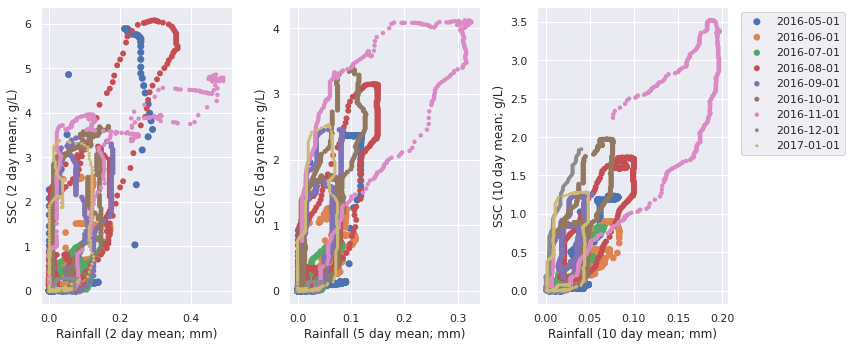

In [32]:
plt.figure(figsize=(12,5))
dates_start = []
for day in pd.date_range(start='05/01/2016', end='01/01/2017', freq='MS').to_list():
    dates_start.append(day)
dates_end = []
for day in pd.date_range(start='05/01/2016', end='02/01/2017', freq='M').to_list():
    dates_end.append(day)
events = []
for i, date_start in enumerate(dates_start):
    date_end = dates_end[i]
    events.append(seds_all.index[(seds_all.index >= date_start) & (seds_all.index <= date_end)].to_list())
    
nplot = 130
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    
    sizes = np.linspace(50, 10, len(dates_start))
    for i, event in enumerate(events):
        g = sns.scatterplot(x = seds_all['Rainfall Rolling Mean. ' + str(window)][event],
                            y = seds_all['Suspended Rolling Mean. ' + str(window)][event], ax=ax1, s=sizes[i], edgecolor='none')
    g.set_xlabel('Rainfall ({} day mean; mm)'.format(window))
    g.set_ylabel('SSC ({} day mean; g/L)'.format(window))
    if nplot == 133:
        label = []
        for day in dates_start:
            label.append(str(day.date()))
        plt.legend(label, bbox_to_anchor=(1.04,1))
    
plt.tight_layout()
plt.savefig('plots/suss_time_average_{}.png'.format(name), dpi=300)
plt.show()

<Figure size 1080x1080 with 0 Axes>

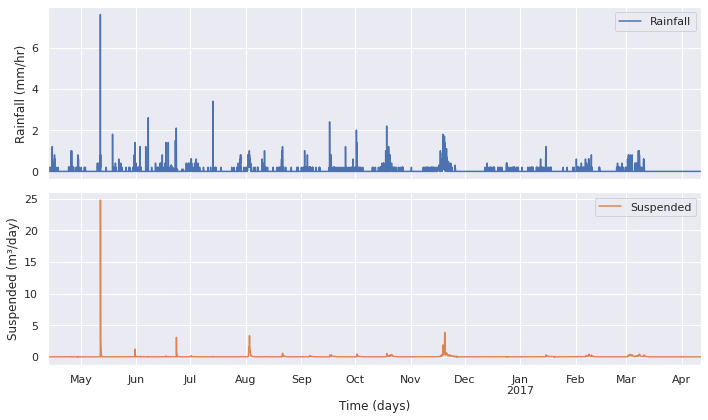

In [33]:
plt.figure()
sns.set(rc={'figure.figsize':(10,6)})
cols_plot = ['Rainfall', 'Suspended']
cols_label = ['Rainfall (mm/hr)', 'Suspended (m³/day)']
axes = seds_all[cols_plot][10:].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Time (days)')
plt.tight_layout()
#plt.savefig('sub_tseries.png')
plt.show()